In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import optuna
import wandb
import gc

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("TensorFlow is using the GPU \n", gpus)
else:
    print("No GPU detected.")
    
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow is using the GPU 
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
os.makedirs("/workspace/Optuna-Trials/Plant-Pathology-Classificator-Conv2D-Trials", exist_ok = True)

In [4]:
gc.collect()
tf.keras.backend.clear_session()

In [5]:
from wandb.integration.keras import WandbMetricsLogger

wandb.require("core")
wandb.login()

wandb: WARNING `wandb.require('core')` is a no-op as it is now the default behavior.
wandb: Currently logged in as: emmdaz (emmdaz-zzz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
# Carga de los datos 

df = pd.read_csv("/Plant-Pathology-Classificator/plant-pathology-2020-/train.csv")
df.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [7]:
import os

df["label"] = df[["healthy", "multiple_diseases", "rust", "scab"]].idxmax(axis=1)

df["filepath"] = df['image_id'].apply(lambda x: os.path.join("/Plant-Pathology-Classificator/plant-pathology-2020-/images", f'{x}.jpg'))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_temp = train_test_split(df, test_size = 0.5, stratify = df["label"], random_state = 4)

X_test, X_val = train_test_split(X_temp, test_size = 0.4, stratify = X_temp["label"], random_state = 4)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 910
Validation size: 365
Test size: 546


In [9]:
mini_train, _ = train_test_split(X_train, test_size = 0.6, stratify = X_train["label"], random_state = 4)

mini_val, _ = train_test_split(X_val, test_size = 0.2, stratify = X_val["label"], random_state = 4)

print("Small training size:", len(mini_train))
print("Small val size:", len(mini_val))

Small training size: 364
Small val size: 292


In [10]:
def color_saturation_filter(img):
    
    # Convertir a uint8
    if img.dtype == np.float32 and img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)

    # Convertir RGB a HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)

    # Rangos de matiz
    red_mask1 = (h < 10)
    red_mask2 = (h > 170)
    orange_yellow_mask = (h >= 10) & (h <= 30)
    green_mask = (h >= 35) & (h <= 85)
    cyan_blue_mask = (h >= 90) & (h <= 130)

    # Saturar rojo, naranja y amarillo
    s[red_mask1 | red_mask2 | orange_yellow_mask] *= 3.0

    # Disminuir tonos azules
    s[cyan_blue_mask] *= 0.7
    
    # Disminuir saturación del verde
    s[green_mask] *= 0.7   

    # Disminuir luminancia del verde
    v[green_mask] *= 0.85 

    # Recortar valores a [0,255]
    s = np.clip(s, 0, 255)
    v = np.clip(v, 0, 255)

    # Juntar y convertir en RGB
    hsv_mod = cv2.merge([h, s, v]).astype(np.uint8)
    rgb_mod = cv2.cvtColor(hsv_mod, cv2.COLOR_HSV2RGB)

    return rgb_mod.astype(np.float32)


In [11]:
def custom_preprocessing(img):

    img = color_saturation_filter(img)
    
    return img

In [12]:
datagen_train = ImageDataGenerator(
    preprocessing_function = custom_preprocessing,
    rescale = 1./255,
    rotation_range = 0.01 ,          
    width_shift_range = 0.02,      
    height_shift_range = 0.02,     
    shear_range = 0.2,            
    horizontal_flip = True,       
    vertical_flip = True,         
    brightness_range = (1.0, 1.12),
    channel_shift_range = 30.0,
    fill_mode = "nearest")

datagen_test_and_val = ImageDataGenerator(rescale = 1./255,
                                          preprocessing_function = custom_preprocessing,
                                          dtype = "float32")

In [13]:
train = datagen_train.flow_from_dataframe(
    dataframe = X_train,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True,
    seed = 4,
)

test = datagen_test_and_val.flow_from_dataframe(
    dataframe = X_test,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False,
    seed = 4
)

val = datagen_test_and_val.flow_from_dataframe(
    dataframe = X_val,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    shuffle = False,  
    seed = 4
)

mini_train = datagen_train.flow_from_dataframe(
    dataframe = mini_train,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True,
    seed = 4
)

mini_val = datagen_test_and_val.flow_from_dataframe(
    dataframe = mini_val,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False,
    seed = 4,
)

Found 910 validated image filenames belonging to 4 classes.
Found 546 validated image filenames belonging to 4 classes.
Found 365 validated image filenames belonging to 4 classes.
Found 364 validated image filenames belonging to 4 classes.
Found 292 validated image filenames belonging to 4 classes.


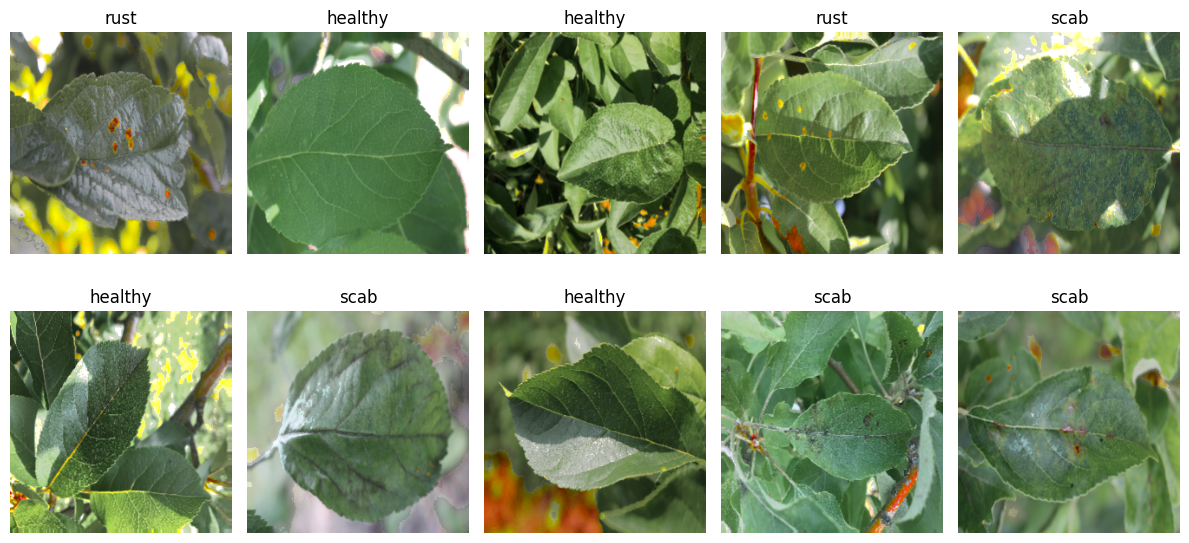

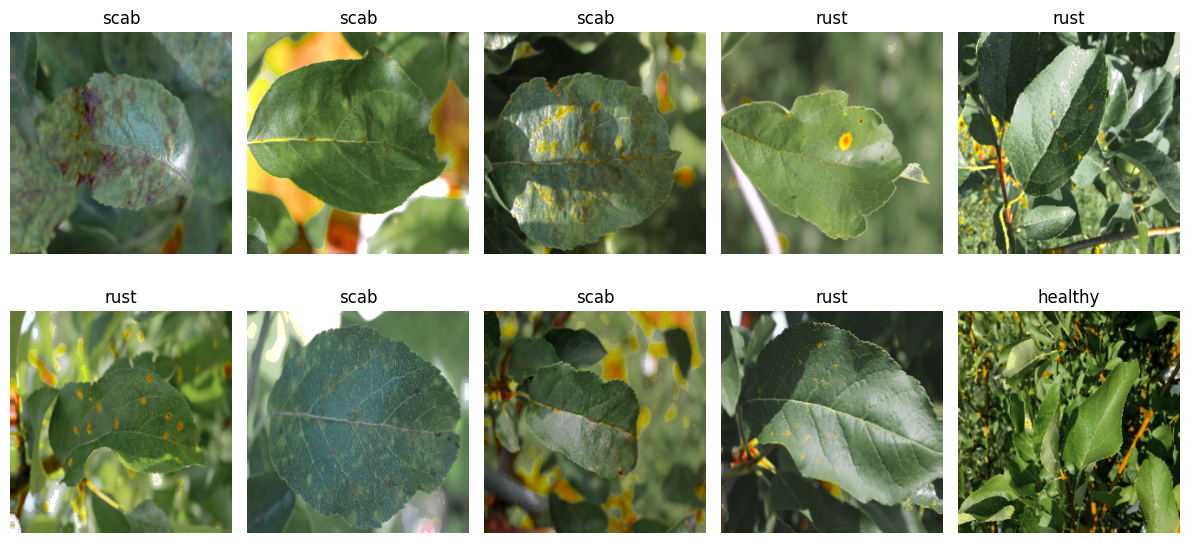

In [14]:
img, labels = next(train)

label_indices = np.argmax(labels, axis=1)
class_names = list(train.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

img, labels = next(mini_train)

label_indices = np.argmax(labels, axis=1)
class_names = list(mini_train.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

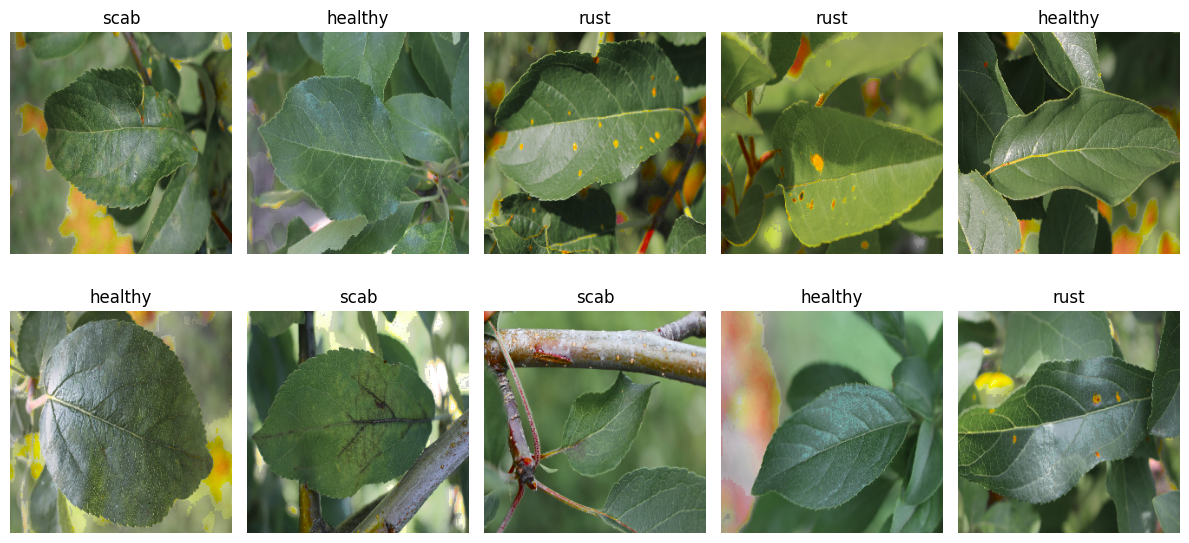

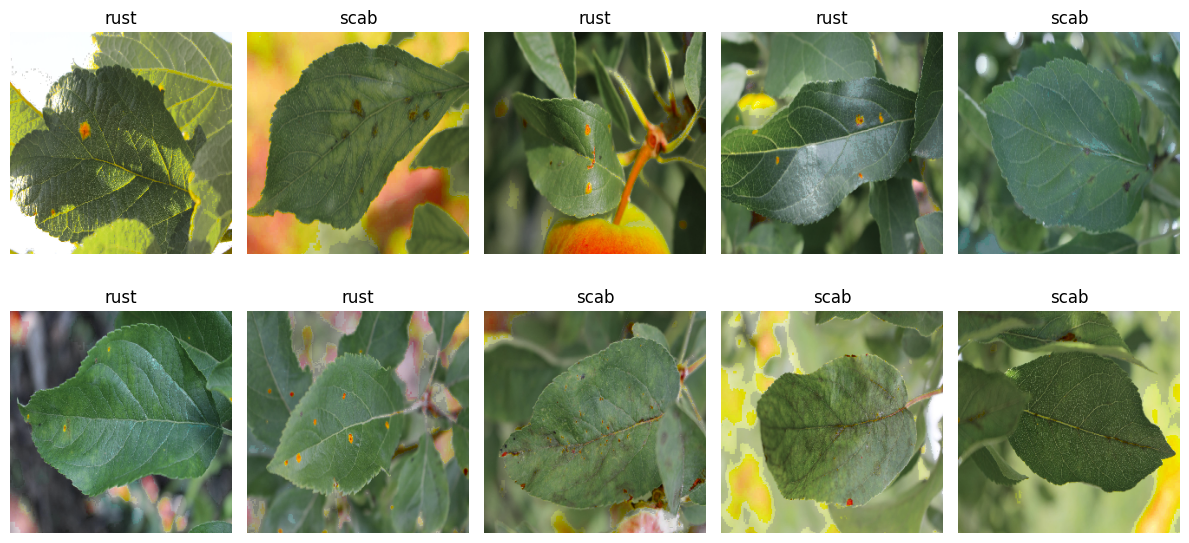

In [15]:
img, labels = next(val)

label_indices = np.argmax(labels, axis=1)
class_names = list(val.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

img, labels = next(mini_val)

label_indices = np.argmax(labels, axis=1)
class_names = list(mini_val.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [17]:
def objective(trial):

    tf.keras.backend.clear_session()
    
    model = models.Sequential()
    inputs = layers.Input(shape=(128, 128, 3))

    x = layers.Conv2D(16, (2,2), padding = "same")(inputs)
    x = layers.Activation("relu")(x)
    
    kernel = trial.suggest_int("Kernel",9,16)
    kernels = [0.0,0.0,0.0]
    
    regularizers = [0.0,0.0,0.0]
    dropout = [0.0,0.0,0.0]
    
    for i in range (3):
        
        kernels[i] = (kernel*2**(i+1))
        
        r = trial.suggest_float(f"regularizador_{i}", 1e-6, 1e-4)
        regularizers[i] = r
        
        d = trial.suggest_float(f"Dropout{i}", 0.1,0.2)
        dropout[i] = r
    
    for k in range(3):
        
        filters = kernels[k]
        r_2 = regularizers[k]
        drop = dropout[k]

        x = layers.Conv2D(filters, (3,3), activation = "relu", padding = "same",
                         kernel_regularizer = tf.keras.regularizers.l2(r_2))(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(filters, (3,3), activation = "relu", padding = "same",
                         kernel_regularizer = tf.keras.regularizers.l2(r_2))(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D((2,2))(x)
        x = layers.Dropout(drop)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(4, activation = "softmax", dtype = "float32")(x)

    model = models.Model(inputs, outputs)
    
    model.summary()
    
    early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
    lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5)

    optimizer_name = trial.suggest_categorical("Optimizador", ["Adam", "RMSprop"])
    
    lr = trial.suggest_float("Learning_rate", 1e-6, 1e-3, log = True)
    
    if optimizer_name == "Adam":
        
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
        
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr)
    
    model.compile(optimizer = optimizer,
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])
    
    wandb.init(
        project = "Experimentos-Conv2D-Series-1",
        name = f"Trial_{trial.number}",
        reinit = True,
        config = {
            "kernel_1": 16,
            "size_1": 2,
            "activation": "Relu",
            "n_layers": 3,
            "kernel_2": kernels[0],
            "kernel_2_size": (3,3),
            "kernel_3": kernels[1],
            "kernel_3_size": (3,3),
            "kernel_4": kernels[2],
            "kernel_4_size": (3,3),
            "regularizer": "L2",
            "r_21": regularizers[0],
            "r_22": regularizers[1],
            "r_23": regularizers[2],
            "Dropout_1": dropout[0],
            "Dropout_1": dropout[1],
            "Dropout_1": dropout[2],
            "learning_rate": lr,
            "optimizer": optimizer_name,
        }
    )
    
    #############################################################################################################
    
    """
    Callbacks
    """
    early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, restore_best_weights = True)
    lr_reduction = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 7)
    
    #############################################################################################################
    
    """
    Creación del modelo
    """
    
    try:
        print(model.summary())
    
        history = model.fit(
            train,
            validation_data = val,
            epochs = 200,
            verbose = 1, 
            callbacks = [WandbMetricsLogger(log_freq = 5), early_stopping, lr_reduction]
        )
    #############################################################################################################
       
        val_loss = min(history.history["val_loss"])
        val_accuracy = max(history.history["val_accuracy"])
        
        train_loss = min(history.history["loss"])
        train_accuracy = max(history.history["accuracy"])
    
    #############################################################################################################
    
    except tf.errors.ResourceExhaustedError as e:
        
        print(f"Intento {trial.number} falló debido a: {e}")
        
        tf.keras.backend.clear_session()
        wandb.finish()
        gc.collect()
        
        return float("inf")

    except Exception as e:
        
        print(f"Intento {trial.number} falló. Unexpected error: {e}")
        
        tf.keras.backend.clear_session()
        wandb.finish()
        gc.collect()
        
        return float("inf")
        
    score = train_loss
        
    tf.keras.backend.clear_session()
    gc.collect()
    wandb.finish()

    return score

In [ ]:
study = optuna.create_study(
    study_name = "Experimentos-Conv2D-Trials-Filter-Serie-1",
    direction = "minimize",
    storage = "sqlite:////workspace/Optuna-Trials/Plant-Pathology-Classificator-Conv2D-Trials/Conv2D_study.db",
    load_if_exists = True
)

study.optimize(objective, n_trials = 500)

[I 2025-11-10 14:18:40,397] Using an existing study with name 'Experimentos-Conv2D-Trials-Filter-Serie-1' instead of creating a new one.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 24)      3480      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 24)     96        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 24)      5208      
                                                             

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 24)      3480      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 24)     96        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 24)      5208      
                                                             

29/29 [==============================] - 21s 723ms/step - loss: 0.5341 - accuracy: 0.8242 - val_loss: 0.6339 - val_accuracy: 0.7945 - lr: 7.1824e-05
Epoch 27/200
29/29 [==============================] - 21s 709ms/step - loss: 0.5256 - accuracy: 0.8198 - val_loss: 0.6136 - val_accuracy: 0.7918 - lr: 7.1824e-05
Epoch 28/200
29/29 [==============================] - 21s 710ms/step - loss: 0.4981 - accuracy: 0.8418 - val_loss: 0.6562 - val_accuracy: 0.7726 - lr: 7.1824e-05
Epoch 29/200
29/29 [==============================] - 20s 710ms/step - loss: 0.5283 - accuracy: 0.8231 - val_loss: 0.5909 - val_accuracy: 0.7890 - lr: 7.1824e-05
Epoch 30/200
29/29 [==============================] - 21s 713ms/step - loss: 0.5028 - accuracy: 0.8330 - val_loss: 0.6076 - val_accuracy: 0.7945 - lr: 7.1824e-05
Epoch 31/200
29/29 [==============================] - 21s 719ms/step - loss: 0.5371 - accuracy: 0.8011 - val_loss: 0.5923 - val_accuracy: 0.7890 - lr: 7.1824e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 14:42:21,701] Trial 216 finished with value: 0.397495836019516 and parameters: {'Kernel': 12, 'regularizador_0': 3.460178930344891e-05, 'Dropout0': 0.15458466933892595, 'regularizador_1': 5.378792470747293e-05, 'Dropout1': 0.13784687155710665, 'regularizador_2': 4.984359055052547e-05, 'Dropout2': 0.19392395895655534, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0007182433111732757}. Best is trial 216 with value: 0.397495836019516.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 24)      3480      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 24)     96        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 24)      5208      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 24)      3480      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 24)     96        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 24)      5208      
                                                             

29/29 [==============================] - 21s 719ms/step - loss: 0.6581 - accuracy: 0.7582 - val_loss: 0.7513 - val_accuracy: 0.7178 - lr: 7.0083e-06
Epoch 27/200
29/29 [==============================] - 21s 722ms/step - loss: 0.6478 - accuracy: 0.7780 - val_loss: 0.7296 - val_accuracy: 0.7288 - lr: 7.0083e-06
Epoch 28/200
29/29 [==============================] - 21s 721ms/step - loss: 0.6621 - accuracy: 0.7725 - val_loss: 0.7176 - val_accuracy: 0.7342 - lr: 7.0083e-06
Epoch 29/200
29/29 [==============================] - 21s 717ms/step - loss: 0.6401 - accuracy: 0.7857 - val_loss: 0.7116 - val_accuracy: 0.7452 - lr: 7.0083e-06
Epoch 30/200
29/29 [==============================] - 21s 703ms/step - loss: 0.6360 - accuracy: 0.7791 - val_loss: 0.7105 - val_accuracy: 0.7589 - lr: 7.0083e-06
Epoch 31/200
29/29 [==============================] - 21s 723ms/step - loss: 0.6332 - accuracy: 0.7868 - val_loss: 0.7053 - val_accuracy: 0.7671 - lr: 7.0083e-06
Epoch 32/200
29/29 [=====================

[I 2025-11-10 14:56:45,017] Trial 217 finished with value: 0.6324458718299866 and parameters: {'Kernel': 12, 'regularizador_0': 3.520475567606731e-05, 'Dropout0': 0.13992101536838494, 'regularizador_1': 5.727312073189497e-05, 'Dropout1': 0.13885063164763273, 'regularizador_2': 4.914202932032982e-05, 'Dropout2': 0.13122500080629637, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0007008340320637296}. Best is trial 216 with value: 0.397495836019516.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 15:00:47,895] Trial 218 finished with value: 0.6874637007713318 and parameters: {'Kernel': 11, 'regularizador_0': 4.461424117919546e-05, 'Dropout0': 0.14175745631750503, 'regularizador_1': 5.808501146932007e-05, 'Dropout1': 0.13902617319160396, 'regularizador_2': 5.054313129646876e-05, 'Dropout2': 0.13141166993730236, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0006847563877523421}. Best is trial 216 with value: 0.397495836019516.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 708ms/step - loss: 0.4809 - accuracy: 0.8418 - val_loss: 0.5512 - val_accuracy: 0.8110 - lr: 6.9410e-05
Epoch 27/200
29/29 [==============================] - 20s 695ms/step - loss: 0.4927 - accuracy: 0.8538 - val_loss: 0.5697 - val_accuracy: 0.7973 - lr: 6.9410e-05
Epoch 28/200
29/29 [==============================] - 21s 710ms/step - loss: 0.4811 - accuracy: 0.8440 - val_loss: 0.5314 - val_accuracy: 0.8247 - lr: 6.9410e-05
Epoch 29/200
29/29 [==============================] - 21s 704ms/step - loss: 0.4599 - accuracy: 0.8670 - val_loss: 0.5451 - val_accuracy: 0.8110 - lr: 6.9410e-05
Epoch 30/200
29/29 [==============================] - 21s 703ms/step - loss: 0.4654 - accuracy: 0.8571 - val_loss: 0.5222 - val_accuracy: 0.8384 - lr: 6.9410e-05
Epoch 31/200
29/29 [==============================] - 21s 711ms/step - loss: 0.4642 - accuracy: 0.8626 - val_loss: 0.5255 - val_accuracy: 0.8110 - lr: 6.9410e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 15:17:34,965] Trial 219 finished with value: 0.3890461325645447 and parameters: {'Kernel': 11, 'regularizador_0': 3.4358541936303585e-05, 'Dropout0': 0.14170255156249242, 'regularizador_1': 5.601975590092424e-05, 'Dropout1': 0.14216420899686544, 'regularizador_2': 5.106950980543006e-05, 'Dropout2': 0.19307130341724466, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0006940969967814261}. Best is trial 219 with value: 0.3890461325645447.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 15:21:28,808] Trial 220 finished with value: 0.6956439018249512 and parameters: {'Kernel': 11, 'regularizador_0': 3.382220323423089e-05, 'Dropout0': 0.14129467227901837, 'regularizador_1': 6.054017950392441e-05, 'Dropout1': 0.14165744240221584, 'regularizador_2': 5.069690630497887e-05, 'Dropout2': 0.1274533561918079, 'Optimizador': 'RMSprop', 'Learning_rate': 0.000721725825927307}. Best is trial 219 with value: 0.3890461325645447.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 15:25:22,418] Trial 221 finished with value: 0.6247455477714539 and parameters: {'Kernel': 11, 'regularizador_0': 3.2929679220709464e-05, 'Dropout0': 0.1419424803557729, 'regularizador_1': 6.0404971244342526e-05, 'Dropout1': 0.14207468833302445, 'regularizador_2': 5.7111133916211165e-05, 'Dropout2': 0.1325791074010043, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0007178362384518451}. Best is trial 219 with value: 0.3890461325645447.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 703ms/step - loss: 0.5416 - accuracy: 0.8231 - val_loss: 0.6362 - val_accuracy: 0.7781 - lr: 7.2171e-05
Epoch 27/200
29/29 [==============================] - 22s 740ms/step - loss: 0.5496 - accuracy: 0.8088 - val_loss: 0.6032 - val_accuracy: 0.7918 - lr: 7.2171e-05
Epoch 28/200
29/29 [==============================] - 21s 712ms/step - loss: 0.5416 - accuracy: 0.8132 - val_loss: 0.6372 - val_accuracy: 0.7726 - lr: 7.2171e-05
Epoch 29/200
29/29 [==============================] - 21s 714ms/step - loss: 0.5109 - accuracy: 0.8319 - val_loss: 0.6056 - val_accuracy: 0.7918 - lr: 7.2171e-05
Epoch 30/200
29/29 [==============================] - 20s 687ms/step - loss: 0.5127 - accuracy: 0.8341 - val_loss: 0.6162 - val_accuracy: 0.8000 - lr: 7.2171e-05
Epoch 31/200
29/29 [==============================] - 21s 731ms/step - loss: 0.5117 - accuracy: 0.8363 - val_loss: 0.5696 - val_accuracy: 0.8082 - lr: 7.2171e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 15:40:05,606] Trial 222 finished with value: 0.4646263122558594 and parameters: {'Kernel': 11, 'regularizador_0': 3.218951783108178e-05, 'Dropout0': 0.14175003982922463, 'regularizador_1': 6.0796859793732445e-05, 'Dropout1': 0.1421405034753153, 'regularizador_2': 5.1197496998902365e-05, 'Dropout2': 0.13062285175110114, 'Optimizador': 'RMSprop', 'Learning_rate': 0.000721706345763628}. Best is trial 219 with value: 0.3890461325645447.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 15:43:59,097] Trial 223 finished with value: 0.6461204886436462 and parameters: {'Kernel': 11, 'regularizador_0': 3.1730650323678354e-05, 'Dropout0': 0.1411873649609343, 'regularizador_1': 6.005651597372217e-05, 'Dropout1': 0.1429195969052554, 'regularizador_2': 5.1629656739026066e-05, 'Dropout2': 0.13006205184280722, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0007190089781386246}. Best is trial 219 with value: 0.3890461325645447.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 708ms/step - loss: 0.5884 - accuracy: 0.8044 - val_loss: 0.6976 - val_accuracy: 0.7370 - lr: 7.4353e-06
Epoch 27/200
29/29 [==============================] - 20s 687ms/step - loss: 0.5878 - accuracy: 0.8077 - val_loss: 0.6764 - val_accuracy: 0.7315 - lr: 7.4353e-06
Epoch 28/200
29/29 [==============================] - 20s 695ms/step - loss: 0.5850 - accuracy: 0.7967 - val_loss: 0.6637 - val_accuracy: 0.7425 - lr: 7.4353e-06
Epoch 29/200
29/29 [==============================] - 21s 700ms/step - loss: 0.5783 - accuracy: 0.8099 - val_loss: 0.6533 - val_accuracy: 0.7534 - lr: 7.4353e-06
Epoch 30/200
29/29 [==============================] - 22s 733ms/step - loss: 0.5750 - accuracy: 0.8022 - val_loss: 0.6466 - val_accuracy: 0.7644 - lr: 7.4353e-06
Epoch 31/200
29/29 [==============================] - 22s 735ms/step - loss: 0.5680 - accuracy: 0.8176 - val_loss: 0.6409 - val_accuracy: 0.7671 - lr: 7.4353e-06
Epoch 32/200
29/29 [=====================

[I 2025-11-10 16:00:00,063] Trial 224 finished with value: 0.5575050711631775 and parameters: {'Kernel': 11, 'regularizador_0': 2.996802526441275e-05, 'Dropout0': 0.14258628945729898, 'regularizador_1': 6.239985513295973e-05, 'Dropout1': 0.1426719823369188, 'regularizador_2': 5.2014270711305566e-05, 'Dropout2': 0.12902518842676985, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0007435277666418472}. Best is trial 219 with value: 0.3890461325645447.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 16:03:53,740] Trial 225 finished with value: 0.6548448204994202 and parameters: {'Kernel': 11, 'regularizador_0': 3.17864175061788e-05, 'Dropout0': 0.1418969580056819, 'regularizador_1': 6.230196898997651e-05, 'Dropout1': 0.14247918937968715, 'regularizador_2': 5.7173711529244516e-05, 'Dropout2': 0.13093254704795343, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0006969757452391211}. Best is trial 219 with value: 0.3890461325645447.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 16:08:11,939] Trial 226 finished with value: 0.7343428730964661 and parameters: {'Kernel': 11, 'regularizador_0': 3.194263458263022e-05, 'Dropout0': 0.1425572870711048, 'regularizador_1': 6.303656140292291e-05, 'Dropout1': 0.14269320397294788, 'regularizador_2': 5.73596745703979e-05, 'Dropout2': 0.13091065716656217, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0007275496511327815}. Best is trial 219 with value: 0.3890461325645447.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 16:12:48,335] Trial 227 finished with value: 0.6935901641845703 and parameters: {'Kernel': 11, 'regularizador_0': 3.406303969458017e-05, 'Dropout0': 0.13972519360263702, 'regularizador_1': 6.664902549168083e-05, 'Dropout1': 0.1458162268817923, 'regularizador_2': 5.244824540143303e-05, 'Dropout2': 0.12891224966693024, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0006866584422927654}. Best is trial 219 with value: 0.3890461325645447.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 16:16:44,601] Trial 228 finished with value: 0.746117889881134 and parameters: {'Kernel': 11, 'regularizador_0': 3.4551014384120944e-05, 'Dropout0': 0.1362654298962132, 'regularizador_1': 6.657276991450617e-05, 'Dropout1': 0.14550494539256162, 'regularizador_2': 5.225101437403406e-05, 'Dropout2': 0.12559862866743107, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0006433228194037485}. Best is trial 219 with value: 0.3890461325645447.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 16:20:37,791] Trial 229 finished with value: 0.6674618124961853 and parameters: {'Kernel': 11, 'regularizador_0': 2.9887468213558047e-05, 'Dropout0': 0.1397675962347158, 'regularizador_1': 6.103206275516219e-05, 'Dropout1': 0.1438495587246313, 'regularizador_2': 5.01520549531985e-05, 'Dropout2': 0.1291546019059788, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0006879205652574071}. Best is trial 219 with value: 0.3890461325645447.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 16:25:21,153] Trial 230 finished with value: 0.6054388880729675 and parameters: {'Kernel': 11, 'regularizador_0': 2.902227167674903e-05, 'Dropout0': 0.1399265833872086, 'regularizador_1': 6.141207752733476e-05, 'Dropout1': 0.14368180805985262, 'regularizador_2': 5.588352898898123e-05, 'Dropout2': 0.1285935849130762, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0007093777666014251}. Best is trial 219 with value: 0.3890461325645447.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 16:29:32,971] Trial 231 finished with value: 0.6296530365943909 and parameters: {'Kernel': 11, 'regularizador_0': 2.93111856854508e-05, 'Dropout0': 0.14050310063025742, 'regularizador_1': 6.170962469462006e-05, 'Dropout1': 0.14402806437164178, 'regularizador_2': 5.624517461578716e-05, 'Dropout2': 0.12775397432796587, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0007192465646028637}. Best is trial 219 with value: 0.3890461325645447.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 20s 695ms/step - loss: 0.4918 - accuracy: 0.8451 - val_loss: 0.5841 - val_accuracy: 0.8027 - lr: 6.8316e-05
Epoch 27/200
29/29 [==============================] - 21s 715ms/step - loss: 0.4702 - accuracy: 0.8484 - val_loss: 0.5518 - val_accuracy: 0.8356 - lr: 6.8316e-05
Epoch 28/200
29/29 [==============================] - 20s 678ms/step - loss: 0.4648 - accuracy: 0.8538 - val_loss: 0.5354 - val_accuracy: 0.8356 - lr: 6.8316e-05
Epoch 29/200
29/29 [==============================] - 21s 725ms/step - loss: 0.4682 - accuracy: 0.8495 - val_loss: 0.5428 - val_accuracy: 0.8219 - lr: 6.8316e-05
Epoch 30/200
29/29 [==============================] - 21s 721ms/step - loss: 0.4830 - accuracy: 0.8418 - val_loss: 0.5314 - val_accuracy: 0.8411 - lr: 6.8316e-05
Epoch 31/200
29/29 [==============================] - 21s 704ms/step - loss: 0.4630 - accuracy: 0.8648 - val_loss: 0.5451 - val_accuracy: 0.8384 - lr: 6.8316e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 16:47:24,277] Trial 232 finished with value: 0.3779909312725067 and parameters: {'Kernel': 11, 'regularizador_0': 2.9962031959216085e-05, 'Dropout0': 0.13924046038837518, 'regularizador_1': 6.116424087008291e-05, 'Dropout1': 0.14370979018718763, 'regularizador_2': 5.5353591328678044e-05, 'Dropout2': 0.1285039543802048, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0006831633197894693}. Best is trial 232 with value: 0.3779909312725067.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 719ms/step - loss: 0.5025 - accuracy: 0.8352 - val_loss: 0.6270 - val_accuracy: 0.7781 - lr: 7.6858e-05
Epoch 27/200
29/29 [==============================] - 21s 717ms/step - loss: 0.4826 - accuracy: 0.8484 - val_loss: 0.6049 - val_accuracy: 0.8055 - lr: 7.6858e-05
Epoch 28/200
29/29 [==============================] - 21s 709ms/step - loss: 0.5081 - accuracy: 0.8363 - val_loss: 0.6068 - val_accuracy: 0.7836 - lr: 7.6858e-05
Epoch 29/200
29/29 [==============================] - 21s 705ms/step - loss: 0.4746 - accuracy: 0.8516 - val_loss: 0.5647 - val_accuracy: 0.8192 - lr: 7.6858e-05
Epoch 30/200
29/29 [==============================] - 21s 704ms/step - loss: 0.4699 - accuracy: 0.8560 - val_loss: 0.5501 - val_accuracy: 0.8219 - lr: 7.6858e-05
Epoch 31/200
29/29 [==============================] - 21s 709ms/step - loss: 0.4787 - accuracy: 0.8429 - val_loss: 0.5624 - val_accuracy: 0.8082 - lr: 7.6858e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 17:04:16,019] Trial 233 finished with value: 0.4013974070549011 and parameters: {'Kernel': 11, 'regularizador_0': 2.9783059148360454e-05, 'Dropout0': 0.13878504945762427, 'regularizador_1': 6.159226988176655e-05, 'Dropout1': 0.14408437415305606, 'regularizador_2': 5.599521994224458e-05, 'Dropout2': 0.12845801764347958, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0007685846720335318}. Best is trial 232 with value: 0.3779909312725067.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 17:08:11,154] Trial 234 finished with value: 0.7046257257461548 and parameters: {'Kernel': 11, 'regularizador_0': 2.902914735818752e-05, 'Dropout0': 0.14072462849376818, 'regularizador_1': 6.137876298936932e-05, 'Dropout1': 0.1441052247727933, 'regularizador_2': 5.554437837574011e-05, 'Dropout2': 0.12768620752997556, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0007667173972400203}. Best is trial 232 with value: 0.3779909312725067.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 22s 733ms/step - loss: 0.5988 - accuracy: 0.8099 - val_loss: 0.6675 - val_accuracy: 0.7699 - lr: 7.3079e-05
Epoch 27/200
29/29 [==============================] - 21s 709ms/step - loss: 0.5759 - accuracy: 0.8187 - val_loss: 0.6709 - val_accuracy: 0.7644 - lr: 7.3079e-05
Epoch 28/200
29/29 [==============================] - 21s 713ms/step - loss: 0.5804 - accuracy: 0.8055 - val_loss: 0.6417 - val_accuracy: 0.7863 - lr: 7.3079e-05
Epoch 29/200
29/29 [==============================] - 21s 725ms/step - loss: 0.5707 - accuracy: 0.8132 - val_loss: 0.6525 - val_accuracy: 0.7836 - lr: 7.3079e-05
Epoch 30/200
29/29 [==============================] - 21s 705ms/step - loss: 0.5726 - accuracy: 0.8044 - val_loss: 0.6470 - val_accuracy: 0.7836 - lr: 7.3079e-05
Epoch 31/200
29/29 [==============================] - 21s 711ms/step - loss: 0.5592 - accuracy: 0.8198 - val_loss: 0.6623 - val_accuracy: 0.7616 - lr: 7.3079e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 17:29:13,576] Trial 235 finished with value: 0.47857987880706787 and parameters: {'Kernel': 11, 'regularizador_0': 2.7565240944567308e-05, 'Dropout0': 0.13926927280650206, 'regularizador_1': 6.508463579509805e-05, 'Dropout1': 0.14166405124441223, 'regularizador_2': 6.0466743712701104e-05, 'Dropout2': 0.1337365534261562, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0007307910451461899}. Best is trial 232 with value: 0.3779909312725067.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 714ms/step - loss: 0.5285 - accuracy: 0.8275 - val_loss: 0.5983 - val_accuracy: 0.7945 - lr: 8.3260e-05
Epoch 27/200
29/29 [==============================] - 21s 719ms/step - loss: 0.5299 - accuracy: 0.8165 - val_loss: 0.5964 - val_accuracy: 0.7945 - lr: 8.3260e-05
Epoch 28/200
29/29 [==============================] - 20s 695ms/step - loss: 0.5202 - accuracy: 0.8220 - val_loss: 0.6243 - val_accuracy: 0.7589 - lr: 8.3260e-05
Epoch 29/200
29/29 [==============================] - 21s 707ms/step - loss: 0.5083 - accuracy: 0.8330 - val_loss: 0.5522 - val_accuracy: 0.8137 - lr: 8.3260e-05
Epoch 30/200
29/29 [==============================] - 21s 698ms/step - loss: 0.5057 - accuracy: 0.8297 - val_loss: 0.5435 - val_accuracy: 0.8411 - lr: 8.3260e-05
Epoch 31/200
29/29 [==============================] - 21s 696ms/step - loss: 0.4933 - accuracy: 0.8407 - val_loss: 0.5562 - val_accuracy: 0.8110 - lr: 8.3260e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 17:43:12,449] Trial 236 finished with value: 0.45534995198249817 and parameters: {'Kernel': 11, 'regularizador_0': 2.750053047318847e-05, 'Dropout0': 0.13864593413897838, 'regularizador_1': 6.364689025980786e-05, 'Dropout1': 0.14621172490880222, 'regularizador_2': 5.674183574830152e-05, 'Dropout2': 0.13159492666971, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008326020068063631}. Best is trial 232 with value: 0.3779909312725067.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 719ms/step - loss: 0.5691 - accuracy: 0.8187 - val_loss: 0.6506 - val_accuracy: 0.7726 - lr: 8.4414e-06
Epoch 27/200
29/29 [==============================] - 21s 717ms/step - loss: 0.5585 - accuracy: 0.8176 - val_loss: 0.6477 - val_accuracy: 0.7808 - lr: 8.4414e-06
Epoch 28/200
29/29 [==============================] - 21s 716ms/step - loss: 0.5507 - accuracy: 0.8330 - val_loss: 0.6374 - val_accuracy: 0.7836 - lr: 8.4414e-06
Epoch 29/200
29/29 [==============================] - 21s 718ms/step - loss: 0.5402 - accuracy: 0.8187 - val_loss: 0.6247 - val_accuracy: 0.7863 - lr: 8.4414e-06
Epoch 30/200
29/29 [==============================] - 21s 713ms/step - loss: 0.5503 - accuracy: 0.8275 - val_loss: 0.6326 - val_accuracy: 0.7918 - lr: 8.4414e-06
Epoch 31/200
29/29 [==============================] - 20s 681ms/step - loss: 0.5563 - accuracy: 0.8165 - val_loss: 0.6239 - val_accuracy: 0.7918 - lr: 8.4414e-06
Epoch 32/200
29/29 [=====================

[I 2025-11-10 17:58:56,613] Trial 237 finished with value: 0.5274998545646667 and parameters: {'Kernel': 11, 'regularizador_0': 2.8148817449968198e-05, 'Dropout0': 0.13866214600992863, 'regularizador_1': 6.476210501051996e-05, 'Dropout1': 0.1454973452922594, 'regularizador_2': 6.116291467781355e-05, 'Dropout2': 0.13328442838577995, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008441388148969001}. Best is trial 232 with value: 0.3779909312725067.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 18:03:32,160] Trial 238 finished with value: 0.6397998929023743 and parameters: {'Kernel': 11, 'regularizador_0': 2.7089475921317578e-05, 'Dropout0': 0.1347831743013439, 'regularizador_1': 6.464871411318935e-05, 'Dropout1': 0.14685870598003656, 'regularizador_2': 6.041567852856026e-05, 'Dropout2': 0.13403216128255177, 'Optimizador': 'RMSprop', 'Learning_rate': 0.000838001309893912}. Best is trial 232 with value: 0.3779909312725067.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 18:07:32,103] Trial 239 finished with value: 0.7449805736541748 and parameters: {'Kernel': 11, 'regularizador_0': 2.681089188586035e-05, 'Dropout0': 0.13356036321563983, 'regularizador_1': 6.476693331256483e-05, 'Dropout1': 0.14722584423009646, 'regularizador_2': 6.138608082671764e-05, 'Dropout2': 0.13415994435736797, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008649241703119224}. Best is trial 232 with value: 0.3779909312725067.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 20s 695ms/step - loss: 0.4948 - accuracy: 0.8363 - val_loss: 0.5822 - val_accuracy: 0.8274 - lr: 8.1389e-05
Epoch 27/200
29/29 [==============================] - 21s 702ms/step - loss: 0.5005 - accuracy: 0.8418 - val_loss: 0.5598 - val_accuracy: 0.8164 - lr: 8.1389e-05
Epoch 28/200
29/29 [==============================] - 21s 716ms/step - loss: 0.4909 - accuracy: 0.8451 - val_loss: 0.5669 - val_accuracy: 0.8301 - lr: 8.1389e-05
Epoch 29/200
29/29 [==============================] - 21s 715ms/step - loss: 0.4834 - accuracy: 0.8495 - val_loss: 0.7986 - val_accuracy: 0.6877 - lr: 8.1389e-05
Epoch 30/200
29/29 [==============================] - 21s 713ms/step - loss: 0.4576 - accuracy: 0.8495 - val_loss: 0.7558 - val_accuracy: 0.7562 - lr: 8.1389e-05
Epoch 31/200
29/29 [==============================] - 21s 699ms/step - loss: 0.4660 - accuracy: 0.8571 - val_loss: 0.5550 - val_accuracy: 0.8356 - lr: 8.1389e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 18:29:34,623] Trial 240 finished with value: 0.34320613741874695 and parameters: {'Kernel': 11, 'regularizador_0': 2.705612225749855e-05, 'Dropout0': 0.13811467321043747, 'regularizador_1': 6.248397589992869e-05, 'Dropout1': 0.14461697020667047, 'regularizador_2': 5.6666531569502346e-05, 'Dropout2': 0.1340827416524473, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008138890790072929}. Best is trial 240 with value: 0.34320613741874695.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 22s 731ms/step - loss: 0.4916 - accuracy: 0.8462 - val_loss: 0.6141 - val_accuracy: 0.8055 - lr: 8.0852e-05
Epoch 27/200
29/29 [==============================] - 20s 692ms/step - loss: 0.4827 - accuracy: 0.8571 - val_loss: 0.5844 - val_accuracy: 0.8000 - lr: 8.0852e-05
Epoch 28/200
29/29 [==============================] - 21s 715ms/step - loss: 0.4845 - accuracy: 0.8505 - val_loss: 0.5795 - val_accuracy: 0.8082 - lr: 8.0852e-05
Epoch 29/200
29/29 [==============================] - 20s 684ms/step - loss: 0.4475 - accuracy: 0.8604 - val_loss: 0.5254 - val_accuracy: 0.8301 - lr: 8.0852e-05
Epoch 30/200
29/29 [==============================] - 21s 712ms/step - loss: 0.4596 - accuracy: 0.8626 - val_loss: 0.5961 - val_accuracy: 0.7863 - lr: 8.0852e-05
Epoch 31/200
29/29 [==============================] - 21s 714ms/step - loss: 0.4701 - accuracy: 0.8451 - val_loss: 0.5440 - val_accuracy: 0.8027 - lr: 8.0852e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 18:44:40,045] Trial 241 finished with value: 0.3954067826271057 and parameters: {'Kernel': 11, 'regularizador_0': 2.635858317029024e-05, 'Dropout0': 0.13816056713964517, 'regularizador_1': 6.295788563032873e-05, 'Dropout1': 0.14350639747159372, 'regularizador_2': 5.724048894454816e-05, 'Dropout2': 0.13422392622333493, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008085173977466143}. Best is trial 240 with value: 0.34320613741874695.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 18:48:33,045] Trial 242 finished with value: 0.7309924364089966 and parameters: {'Kernel': 11, 'regularizador_0': 2.646046865594061e-05, 'Dropout0': 0.13529470492986673, 'regularizador_1': 6.315228872483841e-05, 'Dropout1': 0.1422210346239299, 'regularizador_2': 5.724502984550105e-05, 'Dropout2': 0.1340257861163266, 'Optimizador': 'RMSprop', 'Learning_rate': 0.000984158776235311}. Best is trial 240 with value: 0.34320613741874695.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 706ms/step - loss: 0.4647 - accuracy: 0.8516 - val_loss: 0.5184 - val_accuracy: 0.8329 - lr: 8.2669e-05
Epoch 27/200
29/29 [==============================] - 21s 707ms/step - loss: 0.4605 - accuracy: 0.8516 - val_loss: 0.5014 - val_accuracy: 0.8493 - lr: 8.2669e-05
Epoch 28/200
29/29 [==============================] - 21s 701ms/step - loss: 0.4861 - accuracy: 0.8418 - val_loss: 0.5510 - val_accuracy: 0.8082 - lr: 8.2669e-05
Epoch 29/200
29/29 [==============================] - 21s 723ms/step - loss: 0.4441 - accuracy: 0.8703 - val_loss: 0.5531 - val_accuracy: 0.8164 - lr: 8.2669e-05
Epoch 30/200
29/29 [==============================] - 21s 700ms/step - loss: 0.4585 - accuracy: 0.8495 - val_loss: 0.5526 - val_accuracy: 0.8000 - lr: 8.2669e-05
Epoch 31/200
29/29 [==============================] - 21s 716ms/step - loss: 0.4357 - accuracy: 0.8703 - val_loss: 0.5186 - val_accuracy: 0.8411 - lr: 8.2669e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 19:09:22,584] Trial 243 finished with value: 0.3518854081630707 and parameters: {'Kernel': 11, 'regularizador_0': 2.611759082192245e-05, 'Dropout0': 0.13768225000934065, 'regularizador_1': 6.762340067423001e-05, 'Dropout1': 0.14665653055541295, 'regularizador_2': 6.0068887427785534e-05, 'Dropout2': 0.13260152979872747, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008266854157196804}. Best is trial 240 with value: 0.34320613741874695.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 715ms/step - loss: 0.5188 - accuracy: 0.8297 - val_loss: 0.6097 - val_accuracy: 0.7918 - lr: 8.1552e-05
Epoch 27/200
29/29 [==============================] - 21s 719ms/step - loss: 0.5235 - accuracy: 0.8198 - val_loss: 0.5648 - val_accuracy: 0.8329 - lr: 8.1552e-05
Epoch 28/200
29/29 [==============================] - 21s 704ms/step - loss: 0.5215 - accuracy: 0.8286 - val_loss: 0.5819 - val_accuracy: 0.8027 - lr: 8.1552e-05
Epoch 29/200
29/29 [==============================] - 21s 720ms/step - loss: 0.4982 - accuracy: 0.8473 - val_loss: 0.5343 - val_accuracy: 0.8438 - lr: 8.1552e-05
Epoch 30/200
29/29 [==============================] - 21s 715ms/step - loss: 0.5030 - accuracy: 0.8538 - val_loss: 0.6163 - val_accuracy: 0.8027 - lr: 8.1552e-05
Epoch 31/200
29/29 [==============================] - 21s 707ms/step - loss: 0.4846 - accuracy: 0.8484 - val_loss: 0.5503 - val_accuracy: 0.8247 - lr: 8.1552e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 19:24:51,708] Trial 244 finished with value: 0.4381991922855377 and parameters: {'Kernel': 11, 'regularizador_0': 2.552030977039197e-05, 'Dropout0': 0.13790458230657013, 'regularizador_1': 6.519740200435478e-05, 'Dropout1': 0.1465864287436428, 'regularizador_2': 6.066139776292266e-05, 'Dropout2': 0.13681770650426567, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008155186470424156}. Best is trial 240 with value: 0.34320613741874695.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 22s 736ms/step - loss: 0.5297 - accuracy: 0.8396 - val_loss: 0.6500 - val_accuracy: 0.7808 - lr: 8.8357e-05
Epoch 27/200
29/29 [==============================] - 21s 718ms/step - loss: 0.5341 - accuracy: 0.8275 - val_loss: 0.6292 - val_accuracy: 0.7945 - lr: 8.8357e-05
Epoch 28/200
29/29 [==============================] - 21s 719ms/step - loss: 0.5278 - accuracy: 0.8286 - val_loss: 0.5833 - val_accuracy: 0.8164 - lr: 8.8357e-05
Epoch 29/200
29/29 [==============================] - 21s 707ms/step - loss: 0.5057 - accuracy: 0.8341 - val_loss: 0.5909 - val_accuracy: 0.8110 - lr: 8.8357e-05
Epoch 30/200
29/29 [==============================] - 21s 731ms/step - loss: 0.5172 - accuracy: 0.8286 - val_loss: 0.6392 - val_accuracy: 0.8027 - lr: 8.8357e-05
Epoch 31/200
29/29 [==============================] - 21s 714ms/step - loss: 0.5156 - accuracy: 0.8363 - val_loss: 0.6312 - val_accuracy: 0.7973 - lr: 8.8357e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 19:46:56,679] Trial 245 finished with value: 0.4052414000034332 and parameters: {'Kernel': 11, 'regularizador_0': 2.4270369618959134e-05, 'Dropout0': 0.1382552863659308, 'regularizador_1': 6.74446667996461e-05, 'Dropout1': 0.1471488638677809, 'regularizador_2': 6.056827523596089e-05, 'Dropout2': 0.1352572422861267, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008835746779367339}. Best is trial 240 with value: 0.34320613741874695.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 20s 694ms/step - loss: 0.5271 - accuracy: 0.8418 - val_loss: 0.5781 - val_accuracy: 0.8329 - lr: 8.3141e-06
Epoch 27/200
29/29 [==============================] - 21s 708ms/step - loss: 0.5313 - accuracy: 0.8341 - val_loss: 0.5740 - val_accuracy: 0.8274 - lr: 8.3141e-06
Epoch 28/200
29/29 [==============================] - 21s 712ms/step - loss: 0.5190 - accuracy: 0.8407 - val_loss: 0.5687 - val_accuracy: 0.8247 - lr: 8.3141e-06
Epoch 29/200
29/29 [==============================] - 20s 685ms/step - loss: 0.5312 - accuracy: 0.8374 - val_loss: 0.5657 - val_accuracy: 0.8274 - lr: 8.3141e-06
Epoch 30/200
29/29 [==============================] - 21s 724ms/step - loss: 0.5399 - accuracy: 0.8341 - val_loss: 0.5667 - val_accuracy: 0.8247 - lr: 8.3141e-06
Epoch 31/200
29/29 [==============================] - 21s 713ms/step - loss: 0.5230 - accuracy: 0.8473 - val_loss: 0.5664 - val_accuracy: 0.8219 - lr: 8.3141e-06
Epoch 32/200
29/29 [=====================

[I 2025-11-10 19:59:34,878] Trial 246 finished with value: 0.5025889277458191 and parameters: {'Kernel': 11, 'regularizador_0': 2.3839184307140093e-05, 'Dropout0': 0.13810048668788713, 'regularizador_1': 6.852964098721123e-05, 'Dropout1': 0.14670269656049661, 'regularizador_2': 6.004214661392447e-05, 'Dropout2': 0.13612609426945346, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008314094461182628}. Best is trial 240 with value: 0.34320613741874695.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 704ms/step - loss: 0.4162 - accuracy: 0.8681 - val_loss: 0.4974 - val_accuracy: 0.8192 - lr: 8.0085e-05
Epoch 27/200
29/29 [==============================] - 20s 692ms/step - loss: 0.4097 - accuracy: 0.8747 - val_loss: 0.4834 - val_accuracy: 0.8411 - lr: 8.0085e-05
Epoch 28/200
29/29 [==============================] - 21s 723ms/step - loss: 0.4001 - accuracy: 0.8824 - val_loss: 0.4627 - val_accuracy: 0.8712 - lr: 8.0085e-05
Epoch 29/200
29/29 [==============================] - 21s 719ms/step - loss: 0.4054 - accuracy: 0.8879 - val_loss: 0.4998 - val_accuracy: 0.8301 - lr: 8.0085e-05
Epoch 30/200
29/29 [==============================] - 21s 707ms/step - loss: 0.3904 - accuracy: 0.8879 - val_loss: 0.4405 - val_accuracy: 0.8658 - lr: 8.0085e-05
Epoch 31/200
29/29 [==============================] - 21s 713ms/step - loss: 0.3919 - accuracy: 0.8835 - val_loss: 0.4366 - val_accuracy: 0.8658 - lr: 8.0085e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 20:16:04,765] Trial 247 finished with value: 0.33933117985725403 and parameters: {'Kernel': 11, 'regularizador_0': 2.305266072890802e-05, 'Dropout0': 0.13788732206198168, 'regularizador_1': 6.742185481545807e-05, 'Dropout1': 0.14669695866381643, 'regularizador_2': 6.029301543352178e-05, 'Dropout2': 0.13759350655008273, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008008511418436235}. Best is trial 247 with value: 0.33933117985725403.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 700ms/step - loss: 0.5061 - accuracy: 0.8473 - val_loss: 0.5735 - val_accuracy: 0.7973 - lr: 8.4358e-05
Epoch 27/200
29/29 [==============================] - 21s 725ms/step - loss: 0.4919 - accuracy: 0.8484 - val_loss: 0.5532 - val_accuracy: 0.8274 - lr: 8.4358e-05
Epoch 28/200
29/29 [==============================] - 21s 709ms/step - loss: 0.4886 - accuracy: 0.8451 - val_loss: 0.5407 - val_accuracy: 0.8219 - lr: 8.4358e-05
Epoch 29/200
29/29 [==============================] - 21s 713ms/step - loss: 0.4770 - accuracy: 0.8582 - val_loss: 0.5607 - val_accuracy: 0.8164 - lr: 8.4358e-05
Epoch 30/200
29/29 [==============================] - 21s 719ms/step - loss: 0.4655 - accuracy: 0.8538 - val_loss: 0.5446 - val_accuracy: 0.8274 - lr: 8.4358e-05
Epoch 31/200
29/29 [==============================] - 21s 713ms/step - loss: 0.4510 - accuracy: 0.8505 - val_loss: 0.5485 - val_accuracy: 0.8247 - lr: 8.4358e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 20:32:16,855] Trial 248 finished with value: 0.3986973762512207 and parameters: {'Kernel': 11, 'regularizador_0': 2.347496883000392e-05, 'Dropout0': 0.13759698614747923, 'regularizador_1': 7.025697801333607e-05, 'Dropout1': 0.14707001271651876, 'regularizador_2': 6.0919846183365027e-05, 'Dropout2': 0.13736955669166623, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008435753128406738}. Best is trial 247 with value: 0.33933117985725403.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 706ms/step - loss: 0.5609 - accuracy: 0.8055 - val_loss: 0.6473 - val_accuracy: 0.7616 - lr: 8.3440e-05
Epoch 27/200
29/29 [==============================] - 20s 696ms/step - loss: 0.5492 - accuracy: 0.8132 - val_loss: 0.6492 - val_accuracy: 0.7973 - lr: 8.3440e-05
Epoch 28/200
29/29 [==============================] - 21s 728ms/step - loss: 0.5510 - accuracy: 0.8176 - val_loss: 0.6519 - val_accuracy: 0.7534 - lr: 8.3440e-05
Epoch 29/200
29/29 [==============================] - 22s 738ms/step - loss: 0.5439 - accuracy: 0.8143 - val_loss: 0.6351 - val_accuracy: 0.7973 - lr: 8.3440e-05
Epoch 30/200
29/29 [==============================] - 21s 712ms/step - loss: 0.5640 - accuracy: 0.8099 - val_loss: 0.7532 - val_accuracy: 0.7342 - lr: 8.3440e-05
Epoch 31/200
29/29 [==============================] - 21s 703ms/step - loss: 0.5478 - accuracy: 0.8143 - val_loss: 0.6614 - val_accuracy: 0.7781 - lr: 8.3440e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 20:53:57,161] Trial 249 finished with value: 0.4403076767921448 and parameters: {'Kernel': 11, 'regularizador_0': 2.4195117850612046e-05, 'Dropout0': 0.13798770139879482, 'regularizador_1': 6.762963195293738e-05, 'Dropout1': 0.14528669979250453, 'regularizador_2': 5.99430787354609e-05, 'Dropout2': 0.13723768595418567, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008343981899209312}. Best is trial 247 with value: 0.33933117985725403.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 720ms/step - loss: 0.5321 - accuracy: 0.8264 - val_loss: 0.6198 - val_accuracy: 0.7890 - lr: 8.1870e-05
Epoch 27/200
29/29 [==============================] - 21s 707ms/step - loss: 0.4991 - accuracy: 0.8363 - val_loss: 0.6028 - val_accuracy: 0.8055 - lr: 8.1870e-05
Epoch 28/200
29/29 [==============================] - 21s 735ms/step - loss: 0.4880 - accuracy: 0.8363 - val_loss: 0.5878 - val_accuracy: 0.7945 - lr: 8.1870e-05
Epoch 29/200
29/29 [==============================] - 21s 707ms/step - loss: 0.5025 - accuracy: 0.8352 - val_loss: 0.6049 - val_accuracy: 0.7781 - lr: 8.1870e-05
Epoch 30/200
29/29 [==============================] - 21s 726ms/step - loss: 0.4895 - accuracy: 0.8319 - val_loss: 0.6148 - val_accuracy: 0.7753 - lr: 8.1870e-05
Epoch 31/200
29/29 [==============================] - 21s 704ms/step - loss: 0.4977 - accuracy: 0.8418 - val_loss: 0.5689 - val_accuracy: 0.8110 - lr: 8.1870e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 21:14:34,490] Trial 250 finished with value: 0.38048985600471497 and parameters: {'Kernel': 11, 'regularizador_0': 2.3727686930489435e-05, 'Dropout0': 0.1378269146624245, 'regularizador_1': 6.772373464267711e-05, 'Dropout1': 0.14567836331713233, 'regularizador_2': 5.993739313601587e-05, 'Dropout2': 0.13682574147953747, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008186953091286722}. Best is trial 247 with value: 0.33933117985725403.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 718ms/step - loss: 0.4193 - accuracy: 0.8670 - val_loss: 0.4834 - val_accuracy: 0.8575 - lr: 8.2204e-05
Epoch 27/200
29/29 [==============================] - 23s 779ms/step - loss: 0.4061 - accuracy: 0.8758 - val_loss: 0.5035 - val_accuracy: 0.8384 - lr: 8.2204e-05
Epoch 28/200
29/29 [==============================] - 23s 796ms/step - loss: 0.3940 - accuracy: 0.8791 - val_loss: 0.4977 - val_accuracy: 0.8438 - lr: 8.2204e-05
Epoch 29/200
29/29 [==============================] - 21s 730ms/step - loss: 0.3959 - accuracy: 0.8736 - val_loss: 0.4765 - val_accuracy: 0.8466 - lr: 8.2204e-05
Epoch 30/200
29/29 [==============================] - 22s 733ms/step - loss: 0.4017 - accuracy: 0.8780 - val_loss: 0.4579 - val_accuracy: 0.8603 - lr: 8.2204e-05
Epoch 31/200
29/29 [==============================] - 22s 730ms/step - loss: 0.4027 - accuracy: 0.8758 - val_loss: 0.4500 - val_accuracy: 0.8630 - lr: 8.2204e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 21:35:07,229] Trial 251 finished with value: 0.33455777168273926 and parameters: {'Kernel': 11, 'regularizador_0': 2.368837238181767e-05, 'Dropout0': 0.13744961551264012, 'regularizador_1': 6.836943634931436e-05, 'Dropout1': 0.14546121820281244, 'regularizador_2': 6.408830829997392e-05, 'Dropout2': 0.13791762102870803, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008220440806507021}. Best is trial 251 with value: 0.33455777168273926.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 696ms/step - loss: 0.4323 - accuracy: 0.8571 - val_loss: 0.5698 - val_accuracy: 0.8082 - lr: 8.4715e-05
Epoch 27/200
29/29 [==============================] - 21s 705ms/step - loss: 0.4420 - accuracy: 0.8571 - val_loss: 0.5411 - val_accuracy: 0.8164 - lr: 8.4715e-05
Epoch 28/200
29/29 [==============================] - 20s 690ms/step - loss: 0.4485 - accuracy: 0.8593 - val_loss: 0.4930 - val_accuracy: 0.8411 - lr: 8.4715e-05
Epoch 29/200
29/29 [==============================] - 21s 720ms/step - loss: 0.4360 - accuracy: 0.8725 - val_loss: 0.4816 - val_accuracy: 0.8438 - lr: 8.4715e-05
Epoch 30/200
29/29 [==============================] - 21s 712ms/step - loss: 0.4466 - accuracy: 0.8538 - val_loss: 0.5016 - val_accuracy: 0.8384 - lr: 8.4715e-05
Epoch 31/200
29/29 [==============================] - 21s 705ms/step - loss: 0.4237 - accuracy: 0.8714 - val_loss: 0.5152 - val_accuracy: 0.8438 - lr: 8.4715e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 21:51:14,155] Trial 252 finished with value: 0.3856150209903717 and parameters: {'Kernel': 11, 'regularizador_0': 2.362785479141298e-05, 'Dropout0': 0.13712747771762926, 'regularizador_1': 6.91369357990872e-05, 'Dropout1': 0.14790391937742042, 'regularizador_2': 5.985329663991212e-05, 'Dropout2': 0.1367587353278903, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008471461293537073}. Best is trial 251 with value: 0.33455777168273926.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 21:55:05,414] Trial 253 finished with value: 0.764893651008606 and parameters: {'Kernel': 11, 'regularizador_0': 2.3272305541054493e-05, 'Dropout0': 0.13770722018304737, 'regularizador_1': 6.829131074925391e-05, 'Dropout1': 0.1484908510364939, 'regularizador_2': 6.480770357045094e-05, 'Dropout2': 0.1373841999626173, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0009904921084207526}. Best is trial 251 with value: 0.33455777168273926.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 21:58:59,284] Trial 254 finished with value: 0.7692328691482544 and parameters: {'Kernel': 11, 'regularizador_0': 2.3428103794141725e-05, 'Dropout0': 0.13701716899923863, 'regularizador_1': 7.058786245285815e-05, 'Dropout1': 0.14598221467883818, 'regularizador_2': 5.985659640376857e-05, 'Dropout2': 0.1391745097861313, 'Optimizador': 'RMSprop', 'Learning_rate': 0.000830882796211383}. Best is trial 251 with value: 0.33455777168273926.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

[I 2025-11-10 22:03:24,698] Trial 255 finished with value: 0.6322692036628723 and parameters: {'Kernel': 11, 'regularizador_0': 2.4423225866557425e-05, 'Dropout0': 0.13817465908029194, 'regularizador_1': 6.742297991670337e-05, 'Dropout1': 0.14761088869935485, 'regularizador_2': 6.203786652921727e-05, 'Dropout2': 0.1361287904129358, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008561019172346311}. Best is trial 251 with value: 0.33455777168273926.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 21s 727ms/step - loss: 0.4868 - accuracy: 0.8495 - val_loss: 0.6129 - val_accuracy: 0.8055 - lr: 9.9700e-05
Epoch 27/200
29/29 [==============================] - 21s 723ms/step - loss: 0.4825 - accuracy: 0.8341 - val_loss: 0.6021 - val_accuracy: 0.8219 - lr: 9.9700e-05
Epoch 28/200
29/29 [==============================] - 22s 748ms/step - loss: 0.4868 - accuracy: 0.8527 - val_loss: 0.5795 - val_accuracy: 0.8055 - lr: 9.9700e-05
Epoch 29/200
29/29 [==============================] - 21s 710ms/step - loss: 0.4739 - accuracy: 0.8582 - val_loss: 0.5255 - val_accuracy: 0.8438 - lr: 9.9700e-05
Epoch 30/200
29/29 [==============================] - 22s 737ms/step - loss: 0.4512 - accuracy: 0.8560 - val_loss: 0.5218 - val_accuracy: 0.8521 - lr: 9.9700e-05
Epoch 31/200
29/29 [==============================] - 22s 735ms/step - loss: 0.4581 - accuracy: 0.8615 - val_loss: 0.5682 - val_accuracy: 0.8164 - lr: 9.9700e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 22:21:01,221] Trial 256 finished with value: 0.3889520466327667 and parameters: {'Kernel': 11, 'regularizador_0': 2.0591516430598497e-05, 'Dropout0': 0.1321940765226184, 'regularizador_1': 6.87910491930937e-05, 'Dropout1': 0.1452399664357869, 'regularizador_2': 5.925859427548025e-05, 'Dropout2': 0.13890497810069688, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0009970001197111215}. Best is trial 251 with value: 0.33455777168273926.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

29/29 [==============================] - 20s 695ms/step - loss: 0.4377 - accuracy: 0.8725 - val_loss: 0.5675 - val_accuracy: 0.8164 - lr: 8.1714e-05
Epoch 27/200
29/29 [==============================] - 21s 708ms/step - loss: 0.4215 - accuracy: 0.8604 - val_loss: 0.4997 - val_accuracy: 0.8329 - lr: 8.1714e-05
Epoch 28/200
29/29 [==============================] - 22s 746ms/step - loss: 0.4239 - accuracy: 0.8747 - val_loss: 0.4895 - val_accuracy: 0.8466 - lr: 8.1714e-05
Epoch 29/200
29/29 [==============================] - 21s 728ms/step - loss: 0.4369 - accuracy: 0.8681 - val_loss: 0.4992 - val_accuracy: 0.8466 - lr: 8.1714e-05
Epoch 30/200
29/29 [==============================] - 22s 739ms/step - loss: 0.4340 - accuracy: 0.8615 - val_loss: 0.4882 - val_accuracy: 0.8384 - lr: 8.1714e-05
Epoch 31/200
29/29 [==============================] - 22s 735ms/step - loss: 0.4014 - accuracy: 0.8846 - val_loss: 0.4788 - val_accuracy: 0.8466 - lr: 8.1714e-05
Epoch 32/200
29/29 [=====================

[I 2025-11-10 22:35:58,024] Trial 257 finished with value: 0.3849434554576874 and parameters: {'Kernel': 11, 'regularizador_0': 1.907706488355299e-05, 'Dropout0': 0.12935226220508858, 'regularizador_1': 7.062999096581049e-05, 'Dropout1': 0.14529927393465897, 'regularizador_2': 6.349938625007206e-05, 'Dropout2': 0.14114740923624997, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008171449673561627}. Best is trial 251 with value: 0.33455777168273926.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

In [ ]:
print("Número de pruebas terminadas: ", len(study.trials))

trial = study.best_trial

print("Mejor intento: ", trial)

print("Valor: ", trial.value)
print("Hiperparámetros: ", trial.params)

In [ ]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
import plotly.io as pio

pio.renderers.default = "notebook_connected"

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_param_importances(study)